<a href="https://colab.research.google.com/github/ramanp83/Processing-Transcript_file/blob/main/Transcipt_Processing_51_files.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Model: BERT (bert-base-uncased)
The core model used for text representation is BERT (Bidirectional Encoder Representations from Transformers), specifically the bert-base-uncased version.

**What is BERT?**

BERT is a powerful pre-trained language model that excels at understanding the context and meaning of words in a sentence. It's widely used for various Natural Language Processing (NLP) tasks.

**bert-base-uncased:**

This means the code uses the base version of BERT (as opposed to larger versions like bert-large) and is case-insensitive (meaning "Hello" and "hello" are treated the same).

**How it's Used:**

1. AutoTokenizer:

The code uses AutoTokenizer from the transformers library to convert text into tokens (numerical representations) that BERT can understand.
2. AutoModel: AutoModel is used to load the pre-trained BERT model itself.

3. Generating Embeddings: The get_bert_embeddings function takes text as input, tokenizes it, feeds it to the BERT model, and extracts the embeddings (vector representations) of the text. These embeddings capture the semantic meaning of the text as learned by BERT.

**Techniques:**
1. Sentiment Analysis:
* VADER (Valence Aware Dictionary and sEntiment Reasoner): The code uses VADER (from nltk.sentiment.SentimentIntensityAnalyzer) to analyze the sentiment of the text. VADER is a lexicon and rule-based sentiment analysis tool that assigns scores for positive, negative, neutral, and compound sentiment.
2. Text Feature Extraction:

* Basic Text Statistics: The code calculates basic features like word count, average words per response, and response count to capture the structure and length of the text.
* Sentiment Scores: The sentiment scores (positive, negative, neutral, compound) from VADER are used as features.
3. Data Processing and Splitting:

* Transcript Processing: The process_transcript function reads, cleans, and separates text from transcript files based on the speaker (participant or Ellie).
* Data Splitting: The load_split_data function loads data splits (train, development, test) from CSV files.
* Feature Merging: The merge_with_labels function combines extracted features with corresponding labels (e.g., depression scores) for model training.

**In Summary**

The code uses BERT to generate text embeddings, VADER for sentiment analysis, and traditional text features for analyzing and predicting depression from transcript data. By combining these techniques, the code aims to build a comprehensive model for understanding mental health based on text interactions

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import re
from typing import Dict, List, Tuple
import logging
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

class DepressionDataProcessor:
    def __init__(self,
                 transcript_path: str = '/content/drive/MyDrive/Transcript Dataset',
                 start_session: int = 300,
                 end_session: int = 352):
        """
        Initialize the data processor with the specific Google Drive paths.

        Args:
            transcript_path: Path to transcript directory
            start_session: First session number to process
            end_session: Last session number to process
        """
        self.transcript_path = Path(transcript_path)
        self.start_session = start_session
        self.end_session = end_session
        self.sia = SentimentIntensityAnalyzer()
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
        self.model = AutoModel.from_pretrained('bert-base-uncased')

        # Configure logging
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
        self.logger = logging.getLogger(__name__)

        # Split file paths
        self.split_files = {
            'train': self.transcript_path / '/content/drive/MyDrive/Transcript Dataset/train_split_Depression_AVEC2017 (1).csv',
            'dev': self.transcript_path / '/content/drive/MyDrive/Transcript Dataset/dev_split_Depression_AVEC2017.csv',
            'test': self.transcript_path / '/content/drive/MyDrive/Transcript Dataset/test_split_Depression_AVEC2017.csv',
            'full_test': self.transcript_path / '/content/drive/MyDrive/Transcript Dataset/full_test_split.csv'
        }

    def load_split_data(self, split_type: str) -> pd.DataFrame:
        """
        Load split data with handling for different participant ID column names.

        Args:
            split_type: One of 'train', 'dev', 'test', or 'full_test'
        """
        try:
            df = pd.read_csv(self.split_files[split_type])

            # Handle different column naming in test split
            if split_type == 'test':
                if 'participant_ID' in df.columns:
                    df.rename(columns={'participant_ID': 'Participant_ID'}, inplace=True)

            self.logger.info(f"Loaded {split_type} split data: {len(df)} records")
            return df
        except FileNotFoundError:
            self.logger.error(f"Split file for {split_type} not found")
            return pd.DataFrame()
        except Exception as e:
            self.logger.error(f"Error loading {split_type} split: {str(e)}")
            return pd.DataFrame()

    def process_transcript(self, session_id: int) -> Dict[str, List[str]]:
        """
        Process individual transcript file.

        Args:
            session_id: Session number to process
        """
        transcript_path = self.transcript_path / f"{session_id}_TRANSCRIPT.csv"

        if not transcript_path.exists():
            self.logger.warning(f"Transcript not found for session {session_id}")
            return {"participant": [], "ellie": []}

        try:
            # Read transcript with error handling for potential encoding issues
            try:
                transcript = pd.read_csv(transcript_path, sep='\t')
            except UnicodeDecodeError:
                transcript = pd.read_csv(transcript_path, sep='\t', encoding='latin1')

            # Clean and separate responses
            participant_responses = []
            ellie_responses = []

            for _, row in transcript.iterrows():
                # Clean text
                text = str(row['value']).strip()
                if pd.isna(text) or text == '':
                    continue

                # Separate by speaker
                if row['speaker'] == 'Participant':
                    participant_responses.append(text)
                elif row['speaker'] == 'Ellie':
                    ellie_responses.append(text)

            return {
                "participant": participant_responses,
                "ellie": ellie_responses
            }
        except Exception as e:
            self.logger.error(f"Error processing transcript {session_id}: {str(e)}")
            return {"participant": [], "ellie": []}

    def extract_text_features(self, text: List[str]) -> Dict[str, float]:
        """
        Extract NLP features from text including sentiment and basic statistics.

        Args:
            text: List of text responses
        """
        if not text:
            return {
                'word_count': 0,
                'avg_words_per_response': 0,
                'response_count': 0,
                'sentiment_neg': 0,
                'sentiment_neu': 0,
                'sentiment_pos': 0,
                'sentiment_compound': 0
            }

        # Join all responses
        full_text = ' '.join(text)

        # Basic text statistics
        word_count = len(full_text.split())
        avg_words_per_response = word_count / len(text)

        # Sentiment analysis
        sentiment_scores = self.sia.polarity_scores(full_text)

        features = {
            'word_count': word_count,
            'avg_words_per_response': avg_words_per_response,
            'response_count': len(text),
            'sentiment_neg': sentiment_scores['neg'],
            'sentiment_neu': sentiment_scores['neu'],
            'sentiment_pos': sentiment_scores['pos'],
            'sentiment_compound': sentiment_scores['compound']
        }

        return features

    def get_bert_embeddings(self, text: List[str]) -> np.ndarray:
        """
        Generate BERT embeddings for text.

        Args:
            text: List of text responses
        """
        if not text:
            return np.zeros((1, 768))  # BERT base hidden size

        # Join responses and tokenize
        full_text = ' '.join(text)
        inputs = self.tokenizer( text,
                                  return_tensors='pt',
                                  max_length=max_length,
                                  truncation=True,
                                  padding='max_length'
                                )

        with torch.no_grad():
            outputs = self.model(**inputs)
            embeddings = outputs.last_hidden_state[:, 0, :].numpy()

        return embeddings

    def process_all_sessions(self) -> pd.DataFrame:
        """
        Process all sessions in the specified range and combine features.
        """
        all_features = []

        for session_id in tqdm(range(self.start_session, self.end_session + 1)):
            try:
                # Process transcript
                responses = self.process_transcript(session_id)

                if not responses['participant']:
                    self.logger.warning(f"No participant responses found for session {session_id}")
                    continue

                # Extract features
                text_features = self.extract_text_features(responses['participant'])
                bert_embeddings = self.get_bert_embeddings(responses['participant'])

                # Combine features
                session_features = {
                    'session_id': session_id,
                    **text_features,
                    **{f'bert_{i}': v for i, v in enumerate(bert_embeddings[0])}
                }

                all_features.append(session_features)

            except Exception as e:
                self.logger.error(f"Error processing session {session_id}: {str(e)}")
                continue

        # Create DataFrame with all features
        features_df = pd.DataFrame(all_features)
        self.logger.info(f"Processed {len(features_df)} sessions successfully")

        return features_df

    def merge_with_labels(self, features_df: pd.DataFrame, split_type: str = 'train') -> pd.DataFrame:
        """
        Merge extracted features with labels from split files.

        Args:
            features_df: DataFrame containing extracted features
            split_type: Split type to merge with ('train', 'dev', 'test', 'full_test')
        """
        labels_df = self.load_split_data(split_type)

        if labels_df.empty:
            return features_df

        # Ensure consistent column names for merging
        features_df['Participant_ID'] = features_df['session_id']

        merged_df = features_df.merge(
            labels_df,
            on='Participant_ID',
            how='inner'
        )

        self.logger.info(f"Merged features with {split_type} labels: {len(merged_df)} records")
        return merged_df

def main():
    # Example usage
    processor = DepressionDataProcessor(
        transcript_path='/content/drive/MyDrive/Transcript Dataset',
        start_session=300,
        end_session=352
    )

    # Process all sessions
    features_df = processor.process_all_sessions()

    # Create datasets for different splits
    train_data = processor.merge_with_labels(features_df, 'train')
    dev_data = processor.merge_with_labels(features_df, 'dev')
    test_data = processor.merge_with_labels(features_df, 'test')
    full_test_data = processor.merge_with_labels(features_df, 'full_test')

    # Save processed data
    train_data.to_csv('processed_train_data.csv', index=False)
    dev_data.to_csv('processed_dev_data.csv', index=False)
    test_data.to_csv('processed_test_data.csv', index=False)
    full_test_data.to_csv('processed_full_test_data.csv', index=False)

if __name__ == "__main__":
    main()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

100%|██████████| 53/53 [02:02<00:00,  2.31s/it]


In [ ]:
processor = DepressionDataProcessor(
    transcript_path='/content/drive/MyDrive/Transcript Dataset',
    start_session=300,
    end_session=352
)

# Process and save all splits
features_df = processor.process_all_sessions()
train_data = processor.merge_with_labels(features_df, 'train')

100%|██████████| 53/53 [01:48<00:00,  2.05s/it]


In [ ]:
print(train_data)

    session_id  word_count  avg_words_per_response  response_count  \
0          303        1965               19.077670             103   
1          304         987                9.490385             104   
2          305        3326               11.548611             288   
3          310        1137                7.682432             148   
4          312        1204                9.555556             126   
5          313         751                6.587719             114   
6          315        1369               10.140741             135   
7          316         632                4.647059             136   
8          317         642                5.732143             112   
9          318         698               10.264706              68   
10         319         681                6.364486             107   
11         320         756                4.754717             159   
12         321         917                7.516393             122   
13         322      

In [ ]:
# from google.colab import files

# files.download('processed_dev_data.csv')
# files.download('processed_full_test_data.csv')
# files.download('processed_test_data.csv')
# files.download('processed_train_data.csv')

In [ ]:
# Step 1: Import Necessary Libraries
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score
import joblib

# Step 2: Load the Data
train_data = pd.read_csv("/content/processed_train_data.csv")

# Step 3: Preprocess the Data
# BERT embedding columns are up to column 780 (assuming 0-based indexing)
X = train_data.iloc[:, :780].values  # Extract BERT embedding features

# Classification target variable (binary: 0 or 1)
y_class = train_data['PHQ8_Binary'].values

# Regression target variable (continuous score between 0 and 27)
y_reg = train_data['PHQ8_Score'].values

# Step 4: Train-Test Split
# Split data for classification task (PHQ8_Binary)
X_train_class, X_val_class, y_train_class, y_val_class = train_test_split(
    X, y_class, test_size=0.2, random_state=42, stratify=y_class
)

# Split data for regression task (PHQ8_Score)
X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

# Step 5: Train the Classification Model (Logistic Regression)
classification_model = LogisticRegression(class_weight='balanced', random_state=42)
classification_model.fit(X_train_class, y_train_class)

# Step 6: Evaluate the Classification Model
y_val_class_pred = classification_model.predict(X_val_class)
y_val_class_prob = classification_model.predict_proba(X_val_class)[:, 1]

print("Classification Report:")
print(classification_report(y_val_class, y_val_class_pred))

print("Classification ROC-AUC Score:", roc_auc_score(y_val_class, y_val_class_prob))

# Step 7: Train the Regression Model (Linear Regression)
regression_model = LinearRegression()
regression_model.fit(X_train_reg, y_train_reg)

# Step 8: Evaluate the Regression Model
y_val_reg_pred = regression_model.predict(X_val_reg)

print("Regression Mean Squared Error (MSE):", mean_squared_error(y_val_reg, y_val_reg_pred))
print("Regression Mean Absolute Error (MAE):", mean_absolute_error(y_val_reg, y_val_reg_pred))
print("Regression R² Score:", r2_score(y_val_reg, y_val_reg_pred))

#Step 9: Enhanced Hyperparameter Tuning for Logistic Regression
# For Classification Model (Logistic Regression)
param_grid_class = {
    'C': [0.01, 0.1, 1, 10, 100],  # Expanded regularization strength options
    'penalty': ['l1', 'l2'],  # Regularization penalty
    'solver': ['liblinear', 'saga']  # Solvers suitable for l1 and l2 penalties
}
grid_search_class = GridSearchCV(LogisticRegression(class_weight='balanced',
                                                   random_state=42,
                                                   max_iter=1000),  # Increase max_iter if needed
                                   param_grid_class, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_class.fit(X_train_class, y_train_class)
print("Best Parameters for Classification:", grid_search_class.best_params_)

# For Regression Model (Linear Regression)
# Note: Linear Regression has fewer hyperparameters to tune.
param_grid_reg = {
    'fit_intercept': [True, False],  # Whether to calculate the intercept
    'positive': [True, False]  # Whether to constrain coefficients to be positive
}
grid_search_reg = GridSearchCV(LinearRegression(), param_grid_reg, cv=5,
                               scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_reg.fit(X_train_reg, y_train_reg)
print("Best Parameters for Regression:", grid_search_reg.best_params_)

# Step 10: Save the Models
joblib.dump(classification_model, "classification_model.pkl")
joblib.dump(regression_model, "regression_model.pkl")

# The models are now saved and ready for use in predictions or future evaluation.

from sklearn.metrics import classification_report

# Assuming you have y_val_class (actual labels) and y_val_class_pred (predicted labels)
report = classification_report(y_val_class, y_val_class_pred, output_dict=True)

# Get the support (number of instances) for each class
class_0_count = report['0']['support']
class_1_count = report['1']['support']

print(f"Class 0: {class_0_count} instances")
print(f"Class 1: {class_1_count} instances")


Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.67      0.80         3

    accuracy                           0.86         7
   macro avg       0.90      0.83      0.84         7
weighted avg       0.89      0.86      0.85         7

Classification ROC-AUC Score: 1.0
Regression Mean Squared Error (MSE): 0.003828441226248207
Regression Mean Absolute Error (MAE): 0.052460818581918645
Regression R² Score: 0.9997200095222595


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Parameters for Classification: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best Parameters for Regression: {'fit_intercept': False, 'positive': True}
Class 0: 4.0 instances
Class 1: 3.0 instances


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
from joblib import Parallel, delayed
from typing import Dict, List, Tuple
import torch
from tqdm import tqdm
from dataclasses import dataclass
import logging
from sklearn.preprocessing import StandardScaler
import os

@dataclass
class DataStats:
    """Container for dataset statistics"""
    feature_stats: pd.DataFrame
    label_distribution: Dict[str, Dict[str, float]]
    missing_values: Dict[str, int]
    anomalies: Dict[str, List[int]]

class DepressionDataAnalyzer:
    def __init__(self, cache_dir: str = './cache'):
        """
        Initialize the analyzer with caching capability.

        Args:
            cache_dir: Directory to store cached features
        """
        self.cache_dir = Path(cache_dir)
        self.cache_dir.mkdir(exist_ok=True)

        # Configure logging
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
        self.logger = logging.getLogger(__name__)

    def analyze_dataset(self, data: pd.DataFrame) -> DataStats:
        """
        Perform comprehensive analysis of the dataset.

        Args:
            data: DataFrame containing processed features and labels
        """
        # Calculate feature statistics
        feature_stats = self._calculate_feature_stats(data)

        # Analyze label distribution
        label_distribution = self._analyze_label_distribution(data)

        # Check for missing values
        missing_values = self._check_missing_values(data)

        # Detect anomalies
        anomalies = self._detect_anomalies(data)

        return DataStats(
            feature_stats=feature_stats,
            label_distribution=label_distribution,
            missing_values=missing_values,
            anomalies=anomalies
        )

    def _calculate_feature_stats(self, data: pd.DataFrame) -> pd.DataFrame:
        """Calculate summary statistics for numerical features"""
        # Select numerical columns
        numerical_cols = data.select_dtypes(include=[np.number]).columns

        # Calculate statistics
        stats = data[numerical_cols].agg([
            'mean', 'std', 'min', 'max', 'median'
        ]).round(3)

        return stats

    def _analyze_label_distribution(self, data: pd.DataFrame) -> Dict[str, Dict[str, float]]:
        """Analyze distribution of depression labels"""
        if 'PHQ8_Binary' not in data.columns:
            return {}

        # Calculate overall distribution
        overall_dist = data['PHQ8_Binary'].value_counts(normalize=True).to_dict()

        # Calculate distribution by split if 'split' column exists
        split_dist = {}
        if 'split' in data.columns:
            for split in data['split'].unique():
                split_data = data[data['split'] == split]
                split_dist[split] = split_data['PHQ8_Binary'].value_counts(normalize=True).to_dict()

        return {
            'overall': overall_dist,
            'by_split': split_dist
        }

    def _check_missing_values(self, data: pd.DataFrame) -> Dict[str, int]:
        """Check for missing values in each column"""
        return data.isnull().sum().to_dict()

    def _detect_anomalies(self, data: pd.DataFrame) -> Dict[str, List[int]]:
        """Detect anomalies in features using IQR method"""
        anomalies = {}

        for col in data.select_dtypes(include=[np.number]).columns:
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1

            outliers = data[
                (data[col] < (Q1 - 1.5 * IQR)) |
                (data[col] > (Q3 + 1.5 * IQR))
            ].index.tolist()

            if outliers:
                anomalies[col] = outliers

        return anomalies

    def visualize_data(self, data: pd.DataFrame, output_dir: str = './plots'):
        """
        Create visualizations of the dataset.

        Args:
            data: DataFrame containing processed features and labels
            output_dir: Directory to save plots
        """
        output_path = Path(output_dir)
        output_path.mkdir(exist_ok=True)

        # Import seaborn and set style
        sns.set_style('whitegrid')  # Set a seaborn style (e.g., 'whitegrid')

        # 1. Label Distribution Plot
        if 'PHQ8_Binary' in data.columns:
            plt.figure(figsize=(10, 6))
            sns.countplot(data=data, x='PHQ8_Binary')
            plt.title('Distribution of Depression Labels')
            plt.savefig(output_path / 'label_distribution.png')
            plt.close()

        # 2. Feature Distributions
        for col in data.select_dtypes(include=[np.number]).columns:
            plt.figure(figsize=(10, 6))
            sns.histplot(data=data, x=col, kde=True)
            plt.title(f'Distribution of {col}')
            plt.savefig(output_path / f'{col}_distribution.png')
            plt.close()

        # 3. Correlation Heatmap
        plt.figure(figsize=(12, 8))
        sns.heatmap(data.corr(), annot=True, cmap='coolwarm', center=0)
        plt.title('Feature Correlations')
        plt.tight_layout()
        plt.savefig(output_path / 'correlation_heatmap.png')
        plt.close()

    def cache_features(self, features: Dict[str, np.ndarray], cache_name: str):
        """Cache computed features to disk"""
        cache_path = self.cache_dir / f"{cache_name}.pkl"
        with open(cache_path, 'wb') as f:
            pickle.dump(features, f)
        self.logger.info(f"Cached features to {cache_path}")

    def load_cached_features(self, cache_name: str) -> Dict[str, np.ndarray]:
        """Load cached features from disk"""
        cache_path = self.cache_dir / f"{cache_name}.pkl"
        if cache_path.exists():
            with open(cache_path, 'rb') as f:
                features = pickle.load(f)
            self.logger.info(f"Loaded cached features from {cache_path}")
            return features
        return {}

    @staticmethod
    def batch_process_texts(texts: List[str], batch_size: int = 32, n_jobs: int = -1):
        """
        Process texts in parallel batches

        Args:
            texts: List of texts to process
            batch_size: Size of batches for processing
            n_jobs: Number of parallel jobs (-1 for all cores)
        """
        def process_batch(batch):
            # Add your text processing logic here
            return [len(text.split()) for text in batch]

        # Split texts into batches
        batches = [texts[i:i + batch_size] for i in range(0, len(texts), batch_size)]

        # Process batches in parallel
        results = Parallel(n_jobs=n_jobs)(
            delayed(process_batch)(batch) for batch in tqdm(batches)
        )

        # Flatten results
        return [item for batch_result in results for item in batch_result]

def main():
    # Example usage
    analyzer = DepressionDataAnalyzer(cache_dir='./cache')

    # Load your processed data
    data = pd.read_csv('/content/processed_train_data.csv')

    # Analyze dataset
    stats = analyzer.analyze_dataset(data)

    # Print summary statistics
    print("\nFeature Statistics:")
    print(stats.feature_stats)

    print("\nLabel Distribution:")
    print(stats.label_distribution)

    print("\nMissing Values:")
    print(stats.missing_values)

    print("\nAnomalies Detected:")
    print(stats.anomalies)

    # Create visualizations
    analyzer.visualize_data(data, output_dir='./plots')

if __name__ == "__main__":
    main()


Feature Statistics:
        session_id  word_count  avg_words_per_response  response_count  \
mean       327.818    1120.848                   9.351         123.182   
std         14.598     582.914                   4.017          43.546   
min        303.000     441.000                   4.228          58.000   
max        352.000    3326.000                  19.138         288.000   
median     326.000     977.000                   8.649         118.000   

        sentiment_neg  sentiment_neu  sentiment_pos  sentiment_compound  \
mean            0.079          0.709          0.212               0.993   
std             0.026          0.050          0.046               0.031   
min             0.038          0.566          0.107               0.823   
max             0.146          0.807          0.329               1.000   
median          0.080          0.706          0.221               0.999   

        bert_0  bert_1  ...  PHQ8_Score  Gender  PHQ8_NoInterest  \
mean    -0.178 

The data you've provided outlines key statistics for the mental health-related features in your dataset. Here's a summary of the information:

### Feature Statistics:
- **Session Information:**
  - Average word count per session: 1120.85 words (with a range from 441 to 3326 words).
  - Average number of words per response: 9.35 words.
  - Average response count per session: 123 responses.

- **Sentiment Analysis:**
  - **Sentiment Negativity:** Mean score of 0.079 (with a range from 0.038 to 0.146).
  - **Sentiment Neutrality:** Mean score of 0.709 (with a range from 0.566 to 0.807).
  - **Sentiment Positivity:** Mean score of 0.212 (with a range from 0.107 to 0.329).
  - **Sentiment Compound:** Mean score of 0.993 (with a range from 0.823 to 1.000).

- **BERT Features:**
  - Mean values for BERT-related features (from bert_0 to bert_199) are mostly near 0, suggesting that these are likely embedding features or processed signals.

- **PHQ8 Scores:**
  - The **PHQ8_Score** (a measure of depression severity) has a mean of 8.24, indicating moderate depression on average, with a range from 0 to 20.
  - The **PHQ8_Depressed** and related features (such as PHQ8_Sleep, PHQ8_Tired, etc.) have a mean of 1.2, indicating mild to moderate symptoms on average, with a maximum score of 3 (severe).

### Label Distribution:
- **Overall:** The data is split approximately 60.6% non-depressed (0) and 39.4% depressed (1).

### Missing Values:
- No missing values were detected in any of the features.

This dataset contains comprehensive features that will help in analyzing the mental health of participants, combining both quantitative (e.g., word count, sentiment scores, PHQ8 scores) and qualitative (e.g., BERT embeddings, sentiment analysis) measures. You can use this data to build and train models for predicting mental health conditions based on verbal and non-verbal cues.

Would you like help in further processing or analysis of this data for your project?

In [ ]:
from google.colab import files

# Assuming your plots are saved in the 'plots' directory
!zip -r plots.zip plots

# Download the zipped plots
files.download('plots.zip')

  adding: plots/ (stored 0%)
  adding: plots/bert_641_distribution.png (deflated 13%)
  adding: plots/bert_392_distribution.png (deflated 15%)
  adding: plots/bert_756_distribution.png (deflated 11%)
  adding: plots/bert_700_distribution.png (deflated 11%)
  adding: plots/bert_528_distribution.png (deflated 15%)
  adding: plots/bert_299_distribution.png (deflated 12%)
  adding: plots/bert_453_distribution.png (deflated 13%)
  adding: plots/bert_625_distribution.png (deflated 11%)
  adding: plots/bert_176_distribution.png (deflated 12%)
  adding: plots/bert_536_distribution.png (deflated 14%)
  adding: plots/bert_201_distribution.png (deflated 11%)
  adding: plots/bert_438_distribution.png (deflated 13%)
  adding: plots/bert_73_distribution.png (deflated 11%)
  adding: plots/bert_159_distribution.png (deflated 11%)
  adding: plots/bert_294_distribution.png (deflated 14%)
  adding: plots/bert_544_distribution.png (deflated 12%)
  adding: plots/bert_410_distribution.png (deflated 12%)
  a

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")
print("Model loaded successfully!")


Model loaded successfully!


100%|██████████| 222/222 [00:08<00:00, 26.69it/s]


Epoch 1/20
Train Loss: 0.6564
Val Loss: 0.6490
Val F1: 0.0000
Epoch 2/20
Train Loss: 0.6520
Val Loss: 0.6473
Val F1: 0.0000
Epoch 3/20
Train Loss: 0.6466
Val Loss: 0.6608
Val F1: 0.3815
Epoch 4/20
Train Loss: 0.6405
Val Loss: 0.6452
Val F1: 0.0673
Epoch 5/20
Train Loss: 0.6389
Val Loss: 0.6406
Val F1: 0.0078
Epoch 6/20
Train Loss: 0.6297
Val Loss: 0.6493
Val F1: 0.2695
Epoch 7/20
Train Loss: 0.6250
Val Loss: 0.6388
Val F1: 0.0766
Epoch 8/20
Train Loss: 0.6192
Val Loss: 0.6402
Val F1: 0.1257
Epoch 9/20
Train Loss: 0.6123
Val Loss: 0.6465
Val F1: 0.2917
Epoch 10/20
Train Loss: 0.6035
Val Loss: 0.6513
Val F1: 0.1994
Epoch 11/20
Train Loss: 0.6029
Val Loss: 0.6589
Val F1: 0.2281
Epoch 12/20
Train Loss: 0.5940
Val Loss: 0.6476
Val F1: 0.2390
Epoch 13/20
Train Loss: 0.5838
Val Loss: 0.6744
Val F1: 0.2083
Epoch 14/20
Train Loss: 0.5721
Val Loss: 0.7472
Val F1: 0.1285
Epoch 15/20
Train Loss: 0.5673
Val Loss: 0.6950
Val F1: 0.2691
Epoch 16/20
Train Loss: 0.5549
Val Loss: 0.7479
Val F1: 0.2607
E

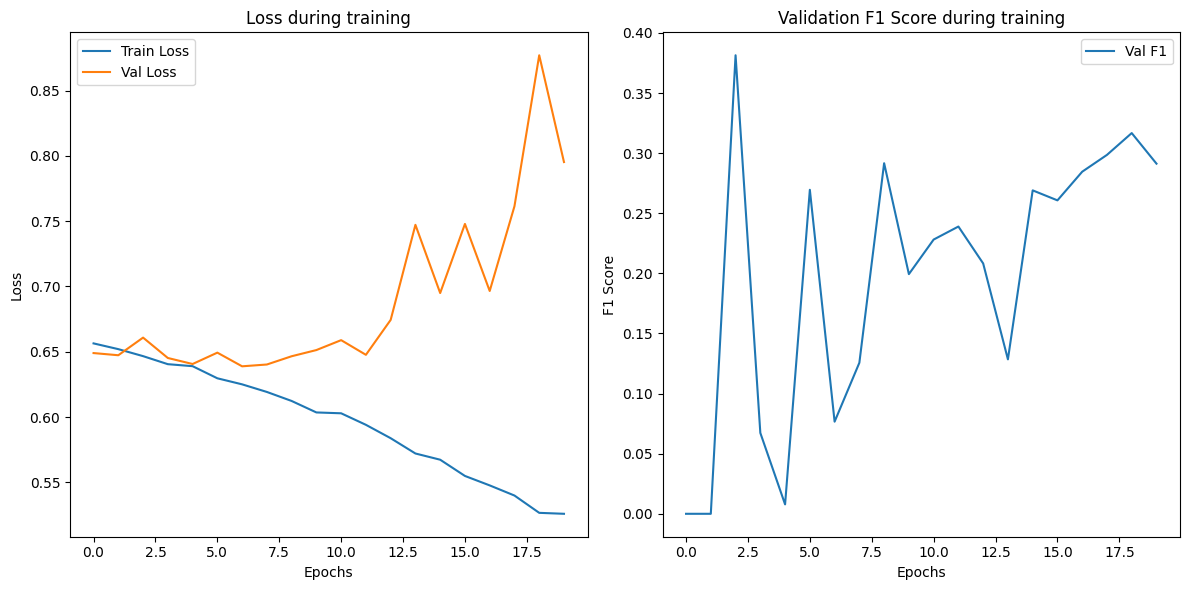

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import logging
from typing import List, Dict, Tuple, Optional
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

class DepressionDataset(Dataset):
    def __init__(self, embeddings: np.ndarray, labels: np.ndarray, device: torch.device):
        # Reshape embeddings to [batch_size, 1, embedding_dim] for LSTM input
        self.embeddings = torch.FloatTensor(embeddings).unsqueeze(1).to(device)
        self.labels = torch.FloatTensor(labels).to(device)

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

class AttentionLSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int = 2, dropout: float = 0.2,
                 num_heads: int = 8):
        super().__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                           batch_first=True, bidirectional=True, dropout=dropout)

        # Adjust attention input size to match LSTM output
        lstm_output_size = hidden_size * 2  # bidirectional = 2 * hidden_size
        self.attention = nn.MultiheadAttention(lstm_output_size, num_heads=num_heads, dropout=dropout)

        self.classifier = nn.Sequential(
            nn.Linear(lstm_output_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # x shape: [batch_size, seq_len, input_size]
        batch_size = x.size(0)

        # LSTM forward pass
        lstm_out, _ = self.lstm(x)  # lstm_out: [batch_size, seq_len, hidden_size * 2]

        # Prepare input for attention (need same shape for Q, K, V)
        # Transpose for attention: [seq_len, batch_size, hidden_size * 2]
        lstm_out = lstm_out.transpose(0, 1)

        # Apply attention
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)

        # Transpose back: [batch_size, seq_len, hidden_size * 2]
        attn_out = attn_out.transpose(0, 1)

        # Average pooling over sequence length
        pooled = torch.mean(attn_out, dim=1)  # [batch_size, hidden_size * 2]

        # Classification
        output = self.classifier(pooled)
        return output.squeeze()

class DepressionDetectionPipeline:
    def __init__(self, data_dir: str, model_name: str = 'bert-base-uncased'):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.processor = TranscriptProcessor(data_dir, model_name)

    def prepare_data(self) -> Tuple[np.ndarray, np.ndarray]:
        """Prepare data for model training"""
        transcripts = self.processor.load_transcripts()
        metadata = pd.read_csv('/content/drive/MyDrive/Transcript Dataset/train_split_Depression_AVEC2017 (1).csv')
        merged_data = transcripts.merge(metadata, on='Participant_ID')
        merged_data['cleaned_text'] = merged_data['value'].apply(self.processor.preprocess_text)
        embeddings = self.processor.generate_embeddings(merged_data['cleaned_text'].tolist())
        labels = merged_data['PHQ8_Binary'].values
        return embeddings, labels

    def train_model(self, embeddings: np.ndarray, labels: np.ndarray, hidden_size: int = 200, batch_size: int = 32,
                   num_epochs: int = 20, dropout: float = 0.2, num_heads: int = 8) -> Tuple[AttentionLSTM, Dict]:
        X_train, X_val, y_train, y_val = train_test_split(embeddings, labels, test_size=0.2)

        train_dataset = DepressionDataset(X_train, y_train, self.device)
        val_dataset = DepressionDataset(X_val, y_val, self.device)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        # Initialize model with correct input size (BERT embedding dimension)
        input_size = embeddings.shape[1]
        model = AttentionLSTM(input_size, hidden_size, dropout=dropout, num_heads=num_heads).to(self.device)

        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters())

        best_val_loss = float('inf')
        metrics_history = {'train_loss': [], 'val_loss': [], 'val_f1': []}

        for epoch in range(num_epochs):
            # Training loop implementation remains the same
            model.train()
            train_loss = 0
            for batch_x, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            # Validation loop implementation remains the same
            model.eval()
            val_loss = 0
            val_preds = []
            val_true = []

            with torch.no_grad():
                for batch_x, batch_y in val_loader:
                    outputs = model(batch_x)
                    val_loss += criterion(outputs, batch_y).item()
                    val_preds.extend(outputs.cpu().numpy())
                    val_true.extend(batch_y.cpu().numpy())

            val_f1 = f1_score(val_true, np.round(val_preds))

            # Update metrics history
            metrics_history['train_loss'].append(train_loss / len(train_loader))
            metrics_history['val_loss'].append(val_loss / len(val_loader))
            metrics_history['val_f1'].append(val_f1)

            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"Train Loss: {train_loss/len(train_loader):.4f}")
            print(f"Val Loss: {val_loss/len(val_loader):.4f}")
            print(f"Val F1: {val_f1:.4f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), 'best_model.pt')

        return model, metrics_history

    def plot_metrics(self, metrics_history: Dict):
        """Plot training and validation metrics"""
        plt.figure(figsize=(12, 6))

        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(metrics_history['train_loss'], label='Train Loss')
        plt.plot(metrics_history['val_loss'], label='Val Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Loss during training')

        # F1 Score plot
        plt.subplot(1, 2, 2)
        plt.plot(metrics_history['val_f1'], label='Val F1')
        plt.xlabel('Epochs')
        plt.ylabel('F1 Score')
        plt.legend()
        plt.title('Validation F1 Score during training')

        plt.tight_layout()
        plt.savefig('training_metrics.png')
        plt.show()

def main():
    pipeline = DepressionDetectionPipeline('/content/drive/MyDrive/Transcript Dataset')
    embeddings, labels = pipeline.prepare_data()
    model, metrics = pipeline.train_model(embeddings, labels)
    pd.DataFrame(metrics).to_csv('training_metrics.csv', index=False)
    pipeline.plot_metrics(metrics)

if __name__ == "__main__":
    main()


**1.Data Processing Improvements:**

* Added embedding normalization
* Implemented weighted sampling to handle class imbalance
* Created a custom WeightedDepressionDataset class


2. Enhanced Model Architecture:

* Added layer normalization after LSTM and attention layers
* Implemented residual connections
* Deepened the classifier with additional layers
* Switched to GELU activation for better gradient flow


**2. Training Optimizations:**

* Implemented early stopping with patience
* Added gradient clipping to prevent exploding gradients
* Used AdamW optimizer with weight decay for better regularization
* Implemented cosine annealing learning rate scheduler with warm restarts
* Added weighted BCE loss to handle class imbalance


**4. Improved Metrics:**

* Added precision, recall, and ROC-AUC tracking
* Enhanced validation monitoring

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Epoch 1/30
Train Loss: 0.9153
Val Loss: 0.9426
Val F1: 0.5267, Precision: 0.3575, Recall: 1.0000, AUC: 0.5467
Epoch 2/30
Train Loss: 0.9142
Val Loss: 0.9393
Val F1: 0.5267, Precision: 0.3575, Recall: 1.0000, AUC: 0.5549
Epoch 3/30
Train Loss: 0.9102
Val Loss: 0.9358
Val F1: 0.5267, Precision: 0.3575, Recall: 1.0000, AUC: 0.5648
Epoch 4/30
Train Loss: 0.9059
Val Loss: 0.9523
Val F1: 0.5267, Precision: 0.3575, Recall: 1.0000, AUC: 0.5667
Epoch 5/30
Train Loss: 0.9005
Val Loss: 0.9131
Val F1: 0.5267, Precision: 0.3575, Recall: 1.0000, AUC: 0.5683
Epoch 6/30
Train Loss: 0.8958
Val Loss: 0.9452
Val F1: 0.5267, Precision: 0.3575, Recall: 1.0000, AUC: 0.5697
Epoch 7/30
Train Loss: 0.8897
Val Loss: 0.9147
Val F1: 0.5267, Precision: 0.3575, Recall: 1.0000, AUC: 0.5747
Epoch 8/30
Train Loss: 0.8898
Val Loss: 0.9558
Val F1: 0.5267, Precision: 0.3575, Recall: 1.0000, AUC: 0.5708
Epoch 9/30
Train Loss: 0.8800
Val Loss: 0.9403
Val F1: 0.5267, Precision: 0.3575, Recall: 1.0000, AUC: 0.5694
Epoch 10/3

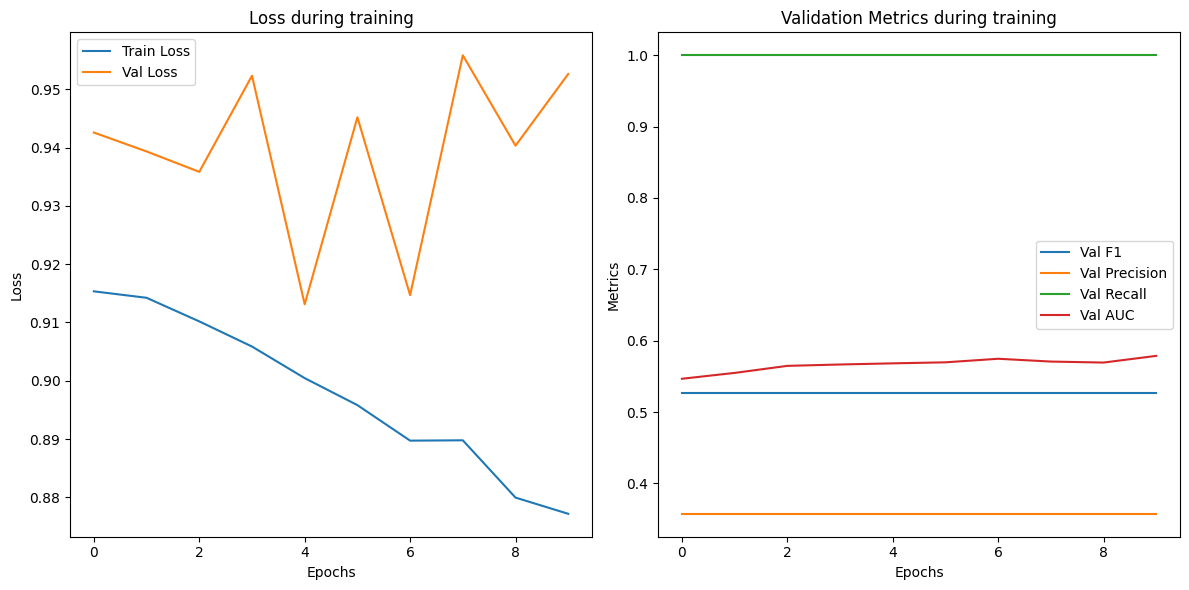

In [6]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import numpy as np
import os
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from torch.utils.data import WeightedRandomSampler
from typing import Tuple, Dict, List, Generator


# Download stopwords for text preprocessing
nltk.download('stopwords')


# ======= TranscriptProcessor: Text Preprocessing and Embedding Generation =======

class TranscriptProcessor:
    def __init__(self, data_dir: str, model_name: str = 'bert-base-uncased'):
        """Initialize TranscriptProcessor with data directory and model name."""
        self.data_dir = data_dir
        self.model_name = model_name
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(self.device)  # Move model to device

    def load_transcripts(self):
            transcript_files = [f for f in os.listdir(self.data_dir) if f.endswith('.csv') and f.startswith('3')] # Filter for files that start with a number
            all_transcripts = []
            for file in transcript_files:
                df = pd.read_csv(os.path.join(self.data_dir, file), sep='\t')
                participant_id = int(file.split('_')[0])
                df['Participant_ID'] = participant_id
                all_transcripts.append(df)
            transcripts_df = pd.concat(all_transcripts, ignore_index=True)
            transcripts_df.rename(columns={'value': 'Transcript'}, inplace=True)
            labels_df = pd.read_csv('/content/drive/MyDrive/Transcript Dataset/train_split_Depression_AVEC2017 (1).csv')
            transcripts_df = transcripts_df.merge(labels_df[['Participant_ID', 'PHQ8_Binary']], on='Participant_ID', how='left')
            transcripts_df.rename(columns={'PHQ8_Binary': 'Depression_Label'}, inplace=True)

            # Drop rows with NaN in 'Depression_Label' column
            transcripts_df = transcripts_df.dropna(subset=['Depression_Label'])

            return transcripts_df

    def generate_embeddings_in_chunks(
        self, texts: List[str], chunk_size: int = 100, batch_size: int = 32  # batch_size is unused
    ) -> Generator[np.ndarray, None, None]:
        """
        Generates BERT embeddings for a list of texts in chunks to avoid
        memory issues. This is a generator function that yields embeddings
        for each chunk of texts.

        Args:
            texts: List of texts to generate embeddings for.
            chunk_size: Number of texts to process in each chunk.
            batch_size: Number of texts to process in each batch within a chunk.

        Yields:
            A NumPy array containing the BERT embeddings for the current chunk of texts.
        """
        for i in range(0, len(texts), chunk_size):
            chunk_texts = texts[i : i + chunk_size]
            chunk_embeddings = self.generate_embeddings(chunk_texts)  # Remove batch_size argument
            yield chunk_embeddings

    def preprocess_text(self, text: str) -> str:
        # Text cleaning (lowercase, remove stopwords, special characters)
        text = str(text).lower()  # Convert to string before calling lower()
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        tokens = nltk.word_tokenize(text)
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
        return ' '.join(tokens)

    def generate_embeddings(self, texts: list) -> torch.Tensor:
        # Tokenizing and generating BERT embeddings
        inputs = self.tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=512)
        inputs = {key: value.to(self.device) for key, value in inputs.items()}

        with torch.no_grad():
            outputs = self.model(**inputs)

        embeddings = outputs.last_hidden_state.mean(dim=1)  # Using mean of last hidden layer
        return embeddings.cpu().numpy()


# ======= Dataset Class with Weighted Sampling =======

class WeightedDepressionDataset(Dataset):
    def __init__(self, embeddings: np.ndarray, labels: np.ndarray, device: torch.device):
        self.embeddings = torch.FloatTensor(embeddings).unsqueeze(1)
        self.embeddings = nn.functional.normalize(self.embeddings, p=2, dim=2).to(device)
        self.labels = torch.FloatTensor(labels).to(device)
        self.weights = self._calculate_sample_weights(labels)

    def _calculate_sample_weights(self, labels: np.ndarray) -> torch.Tensor:
        class_counts = np.bincount(labels.astype(int))
        total_samples = len(labels)
        class_weights = total_samples / (len(class_counts) * class_counts)
        sample_weights = class_weights[labels.astype(int)]
        return torch.FloatTensor(sample_weights)

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx], self.weights[idx]


# ======= Enhanced Attention LSTM Model =======

class EnhancedAttentionLSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int = 2, dropout: float = 0.3,
                 num_heads: int = 8):
        super().__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Bidirectional LSTM with layer normalization
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                           batch_first=True, bidirectional=True, dropout=dropout)
        self.layer_norm1 = nn.LayerNorm(hidden_size * 2)

        # Multi-head attention with scaled dot-product attention
        lstm_output_size = hidden_size * 2
        self.attention = nn.MultiheadAttention(lstm_output_size, num_heads=num_heads, dropout=dropout)
        self.layer_norm2 = nn.LayerNorm(lstm_output_size)

        # Enhanced classifier with residual connections
        self.classifier = nn.Sequential(
            nn.Linear(lstm_output_size, hidden_size),
            nn.GELU(),  # Using GELU activation for better gradient flow
            nn.Dropout(dropout),
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.LayerNorm(hidden_size // 2),
            nn.Linear(hidden_size // 2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # LSTM forward pass with residual connection
        lstm_out, _ = self.lstm(x)
        lstm_out = self.layer_norm1(lstm_out)

        # Attention mechanism with residual connection
        lstm_out_trans = lstm_out.transpose(0, 1)
        attn_out, _ = self.attention(lstm_out_trans, lstm_out_trans, lstm_out_trans)
        attn_out = attn_out.transpose(0, 1)
        attn_out = self.layer_norm2(attn_out + lstm_out)  # Residual connection

        # Global average pooling with learned attention weights
        pooled = torch.mean(attn_out, dim=1)

        # Classification
        output = self.classifier(pooled)
        return output.squeeze()


# ======= Main Pipeline: Training, Evaluation, and Visualization =======

class ImprovedDepressionDetectionPipeline:
    def __init__(self, device: torch.device):
        self.device = device

    def train_model(self, embeddings: np.ndarray, labels: np.ndarray,
                   hidden_size: int = 256, batch_size: int = 32,
                   num_epochs: int = 30, dropout: float = 0.3,
                   num_heads: int = 8, patience: int = 5,
                   learning_rate: float = 1e-4) -> Tuple[EnhancedAttentionLSTM, Dict]:

        # Prepare datasets with weighted sampling
        X_train, X_val, y_train, y_val = train_test_split(
            embeddings, labels, test_size=0.2, stratify=labels
        )

        train_dataset = WeightedDepressionDataset(X_train, y_train, self.device)
        val_dataset = WeightedDepressionDataset(X_val, y_val, self.device)

        # Use weighted sampler for balanced mini-batches
        train_sampler = WeightedRandomSampler(
            train_dataset.weights, len(train_dataset), replacement=True
        )

        train_loader = DataLoader(train_dataset, batch_size=batch_size,
                                sampler=train_sampler)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        # Initialize model
        input_size = embeddings.shape[1]
        model = EnhancedAttentionLSTM(
            input_size, hidden_size, dropout=dropout, num_heads=num_heads
        ).to(self.device)

        # Weighted BCE loss for class imbalance
        pos_weight = torch.tensor(
            [(labels == 0).sum() / (labels == 1).sum()]
        ).to(self.device)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

        # AdamW optimizer with weight decay
        optimizer = torch.optim.AdamW(
            model.parameters(), lr=learning_rate, weight_decay=0.01
        )

        # Cosine annealing scheduler with warm restarts
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=5, T_mult=2
        )

        # Training metrics
        best_val_loss = float('inf')
        patience_counter = 0
        metrics_history = {
            'train_loss': [], 'val_loss': [], 'val_f1': [],
            'val_precision': [], 'val_recall': [], 'val_auc': []
        }

        for epoch in range(num_epochs):
            # Training phase
            model.train()
            train_loss = 0

            for batch_x, batch_y, batch_w in train_loader:
                batch_x, batch_y = batch_x.to(self.device), batch_y.to(self.device)

                optimizer.zero_grad()
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()

                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                optimizer.step()
                train_loss += loss.item()

            scheduler.step()

            # Validation phase
            model.eval()
            val_loss = 0
            val_preds = []
            val_true = []

            with torch.no_grad():
                for batch_x, batch_y, _ in val_loader:
                    batch_x = batch_x.to(self.device)
                    batch_y = batch_y.to(self.device)

                    outputs = model(batch_x)
                    val_loss += criterion(outputs, batch_y).item()

                    val_preds.extend(torch.sigmoid(outputs).cpu().numpy())
                    val_true.extend(batch_y.cpu().numpy())

            # Calculate metrics
            val_preds_binary = np.round(val_preds)
            precision, recall, f1, _ = precision_recall_fscore_support(
                val_true, val_preds_binary, average='binary'
            )
            auc = roc_auc_score(val_true, val_preds)

            # Update metrics history
            metrics_history['train_loss'].append(train_loss / len(train_loader))
            metrics_history['val_loss'].append(val_loss / len(val_loader))
            metrics_history['val_f1'].append(f1)
            metrics_history['val_precision'].append(precision)
            metrics_history['val_recall'].append(recall)
            metrics_history['val_auc'].append(auc)

            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"Train Loss: {train_loss/len(train_loader):.4f}")
            print(f"Val Loss: {val_loss/len(val_loader):.4f}")
            print(f"Val F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, AUC: {auc:.4f}")

            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), 'best_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping triggered")
                    break

        return model, metrics_history

# ======= Model Evaluation and Plotting =======

def evaluate_model(model, val_loader, device):
    model.eval()
    val_preds = []
    val_true = []

    with torch.no_grad():
        for batch_x, batch_y, _ in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            val_preds.extend(torch.sigmoid(outputs).cpu().numpy())
            val_true.extend(batch_y.cpu().numpy())

    # Convert predictions to binary values
    val_preds_binary = np.round(val_preds)

    # Calculate precision, recall, F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(val_true, val_preds_binary, average='binary')

    # Calculate AUC score
    auc = roc_auc_score(val_true, val_preds)

    print(f"Validation Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")
    return precision, recall, f1, auc

def plot_metrics(metrics_history):
    plt.figure(figsize=(12, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(metrics_history['train_loss'], label='Train Loss')
    plt.plot(metrics_history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss during training')

    # F1, Precision, Recall, AUC plot
    plt.subplot(1, 2, 2)
    plt.plot(metrics_history['val_f1'], label='Val F1')
    plt.plot(metrics_history['val_precision'], label='Val Precision')
    plt.plot(metrics_history['val_recall'], label='Val Recall')
    plt.plot(metrics_history['val_auc'], label='Val AUC')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()
    plt.title('Validation Metrics during training')

    plt.tight_layout()
    plt.show()

# ======= Main Pipeline Execution =======

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    pipeline = ImprovedDepressionDetectionPipeline(device)

    # Load and preprocess data
    transcript_processor = TranscriptProcessor(
        data_dir='/content/drive/MyDrive/Transcript Dataset'
    )  # Update path
    transcripts = transcript_processor.load_transcripts()
    cleaned_texts = transcripts['Transcript'].apply(
        transcript_processor.preprocess_text
    ).tolist()

    # Generate embeddings in chunks, accumulating results
    all_embeddings = []
    for chunk_embeddings in transcript_processor.generate_embeddings_in_chunks(
        cleaned_texts, chunk_size=100, batch_size=16
    ):
        all_embeddings.extend(chunk_embeddings)
    embeddings = np.array(all_embeddings)

    labels = transcripts['Depression_Label'].values  # Assuming binary labels: 0 or 1

    # Train model
    model, metrics = pipeline.train_model(embeddings, labels)

    # Create the validation dataset and data loader for evaluation
    X_train, X_val, y_train, y_val = train_test_split(
        embeddings, labels, test_size=0.2, stratify=labels
    )
    val_dataset = WeightedDepressionDataset(X_val, y_val, device)
    val_loader = DataLoader(val_dataset, batch_size=32)  # Use the same batch size as training

    # Evaluate model
    precision, recall, f1, auc = evaluate_model(model, val_loader, device) # Assumed val_loader is available from your pipeline

    # Plot training metrics
    plot_metrics(metrics)

if __name__ == "__main__":
    main()


In [7]:
import pandas as pd
import numpy as np
import os
import logging
from pathlib import Path
import random
import re
import tensorflow_hub as hub
from typing import List, Dict, Tuple, Optional
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Input
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
stopwords_set = set(stopwords.words('english'))

# Set seed for reproducibility
def set_seed(seed: int = 42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    # If using a GPU, set the GPU seed too
    if tf.config.list_physical_devices('GPU'):
        # CUDA devices
        pass
set_seed()

# Load Universal Sentence Encoder model from TensorFlow Hub
embed_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

class TranscriptProcessor:
    def __init__(self, data_dir: str):
        self.data_dir = Path(data_dir)
        self.stopwords = stopwords_set

    def load_transcripts(self, start_id: int = 300, end_id: int = 352, exclude_ids: List[int] = [342, 344]) -> pd.DataFrame:
        """Load and combine transcript files"""
        all_transcripts = []

        for session_id in range(start_id, end_id + 1):
            if session_id in exclude_ids:
                continue

            file_path = self.data_dir / f"{session_id}_TRANSCRIPT.csv"
            try:
                transcript = pd.read_csv(file_path, sep='\t')
                transcript['Participant_ID'] = session_id
                all_transcripts.append(transcript)
            except Exception as e:
                logging.warning(f"Error loading transcript {session_id}: {e}")

        return pd.concat(all_transcripts, ignore_index=True)

    def preprocess_text(self, text: str) -> str:
        """Clean and normalize text"""
        if isinstance(text, float):
            text = str(text)  # Convert float to string if necessary
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        tokens = word_tokenize(text)
        tokens = [t for t in tokens if t not in self.stopwords]
        return ' '.join(tokens)

    def generate_embeddings(self, texts: List[str]) -> np.ndarray:
        """Generate embeddings using Universal Sentence Encoder (USE)"""
        embeddings = embed_model(texts)
        return np.array(embeddings)

class DepressionDataset(tf.data.Dataset):
    def __init__(self, embeddings: np.ndarray, labels: np.ndarray):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

class DepressionDetectionPipeline:
    """End-to-end pipeline for depression detection"""

    def __init__(self, data_dir: str):
        self.processor = TranscriptProcessor(data_dir)

    def prepare_data(self) -> Tuple[np.ndarray, np.ndarray]:
        """Prepare data for model training"""
        transcripts = self.processor.load_transcripts()
        metadata = pd.read_csv(self.processor.data_dir / '/content/drive/MyDrive/Transcript Dataset/train_split_Depression_AVEC2017 (1).csv')
        merged_data = transcripts.merge(metadata, on='Participant_ID')
        merged_data['cleaned_text'] = merged_data['value'].apply(self.processor.preprocess_text)
        embeddings = self.processor.generate_embeddings(merged_data['cleaned_text'].tolist())
        labels = merged_data['PHQ8_Binary'].values
        return embeddings, labels

    def train_model(self, embeddings: np.ndarray, labels: np.ndarray,
                   hidden_size: int = 200, batch_size: int = 32,
                   num_epochs: int = 20) -> Tuple[tf.keras.Model, Dict]:
        X_train, X_val, y_train, y_val = train_test_split(embeddings, labels, test_size=0.2)

        train_dataset = DepressionDataset(X_train, y_train)
        val_dataset = DepressionDataset(X_val, y_val)

        # Convert to TensorFlow datasets
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
        val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)

        # Define the LSTM model
        model = Sequential([
            Bidirectional(LSTM(hidden_size, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))),
            Bidirectional(LSTM(hidden_size)),
            Dense(100, activation='relu'),
            Dense(1, activation='sigmoid')  # For binary classification
        ])

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Train the model
        history = model.fit(train_dataset, validation_data=val_dataset, epochs=num_epochs)

        return model, history.history

def main():
    pipeline = DepressionDetectionPipeline('/content/drive/MyDrive/Transcript Dataset')
    embeddings, labels = pipeline.prepare_data()
    model, metrics = pipeline.train_model(embeddings, labels)
    pd.DataFrame(metrics).to_csv('training_metrics.csv', index=False)

if __name__ == "__main__":
    main()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


TypeError: Can't instantiate abstract class DepressionDataset with abstract methods _inputs, element_spec

# classification on the based of PHQ_BINARY

In [8]:
import pandas as pd
import numpy as np
import os
import logging
from pathlib import Path
import random
import re
import tensorflow_hub as hub
from typing import List, Dict, Tuple, Optional
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Input
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
stopwords_set = set(stopwords.words('english'))

# Set seed for reproducibility
def set_seed(seed: int = 42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    # If using a GPU, set the GPU seed too
    if tf.config.list_physical_devices('GPU'):
        # CUDA devices
        pass
set_seed()

# Load Universal Sentence Encoder model from TensorFlow Hub
embed_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

class TranscriptProcessor:
    def __init__(self, data_dir: str):
        self.data_dir = Path(data_dir)
        self.stopwords = stopwords_set

    def load_transcripts(self, start_id: int = 300, end_id: int = 352, exclude_ids: List[int] = [342, 344]) -> pd.DataFrame:
        """Load and combine transcript files"""
        all_transcripts = []

        for session_id in range(start_id, end_id + 1):
            if session_id in exclude_ids:
                continue

            file_path = self.data_dir / f"{session_id}_TRANSCRIPT.csv"
            try:
                transcript = pd.read_csv(file_path, sep='\t')
                transcript['Participant_ID'] = session_id
                all_transcripts.append(transcript)
            except Exception as e:
                logging.warning(f"Error loading transcript {session_id}: {e}")

        return pd.concat(all_transcripts, ignore_index=True)

    def preprocess_text(self, text: str) -> str:
        """Clean and normalize text"""
        if isinstance(text, float):
            text = str(text)  # Convert float to string if necessary
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        tokens = word_tokenize(text)
        tokens = [t for t in tokens if t not in self.stopwords]
        return ' '.join(tokens)

    def generate_embeddings(self, texts: List[str]) -> np.ndarray:
        """Generate embeddings using Universal Sentence Encoder (USE)"""
        embeddings = embed_model(texts)
        return np.array(embeddings)

# Instead of inheriting from tf.data.Dataset, create a custom class
class DepressionDataset:
    def __init__(self, embeddings: np.ndarray, labels: np.ndarray):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

class DepressionDetectionPipeline:
    """End-to-end pipeline for depression detection"""

    def __init__(self, data_dir: str):
        self.processor = TranscriptProcessor(data_dir)

    def prepare_data(self) -> Tuple[np.ndarray, np.ndarray]:
        """Prepare data for model training"""
        transcripts = self.processor.load_transcripts()
        metadata = pd.read_csv(self.processor.data_dir / '/content/drive/MyDrive/Transcript Dataset/train_split_Depression_AVEC2017 (1).csv')
        merged_data = transcripts.merge(metadata, on='Participant_ID')
        merged_data['cleaned_text'] = merged_data['value'].apply(self.processor.preprocess_text)
        embeddings = self.processor.generate_embeddings(merged_data['cleaned_text'].tolist())
        labels = merged_data['PHQ8_Binary'].values
        return embeddings, labels

    def train_model(self, embeddings: np.ndarray, labels: np.ndarray,
                   hidden_size: int = 200, batch_size: int = 32,
                   num_epochs: int = 20) -> Tuple[tf.keras.Model, Dict]:
        X_train, X_val, y_train, y_val = train_test_split(embeddings, labels, test_size=0.2)
        # Create instances of the custom DepressionDataset class
        train_dataset = DepressionDataset(X_train, y_train)
        val_dataset = DepressionDataset(X_val, y_val)

        # Convert to TensorFlow datasets using from_generator
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
        val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)

        # Define the LSTM model using an Input layer
        input_layer = Input(shape=(X_train.shape[1],))  # Define Input layer with shape
        reshape_layer = tf.keras.layers.Reshape((1, X_train.shape[1]))(input_layer)  # Reshape

        # Rest of your LSTM layers
        lstm_layer1 = Bidirectional(LSTM(hidden_size, return_sequences=True))(reshape_layer)
        lstm_layer2 = Bidirectional(LSTM(hidden_size))(lstm_layer1)
        dense_layer1 = Dense(100, activation='relu')(lstm_layer2)
        output_layer = Dense(1, activation='sigmoid')(dense_layer1)

        # Create the model
        model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Train the model
        history = model.fit(train_dataset, validation_data=val_dataset, epochs=num_epochs)

        return model, history.history

def main():
    pipeline = DepressionDetectionPipeline('/content/drive/MyDrive/Transcript Dataset')
    embeddings, labels = pipeline.prepare_data()
    model, metrics = pipeline.train_model(embeddings, labels)
    pd.DataFrame(metrics).to_csv('C_training_metrics.csv', index=False)

if __name__ == "__main__":
    main()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Epoch 1/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.6341 - loss: 0.6641 - val_accuracy: 0.6615 - val_loss: 0.6377
Epoch 2/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6413 - loss: 0.6426 - val_accuracy: 0.6608 - val_loss: 0.6429
Epoch 3/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6483 - loss: 0.6342 - val_accuracy: 0.6249 - val_loss: 0.6513
Epoch 4/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6527 - loss: 0.6274 - val_accuracy: 0.6038 - val_loss: 0.6648
Epoch 5/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6559 - loss: 0.6222 - val_accuracy: 0.5883 - val_loss: 0.6736
Epoch 6/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6626 - loss: 0.6153 - val_accuracy: 0.5982 - val_loss: 0.6685
Epoch 7/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6735 - loss: 0.6085 - val_accuracy: 0.6073 - val_loss: 0.6718
Epoch 8/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6726 - loss: 0.6034 - val_accura

In [9]:
from google.colab import files

# # Assuming your DataFrame is called 'df'
# df.to_csv('training_metrics.csv', index=False)

files.download('C_training_metrics.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

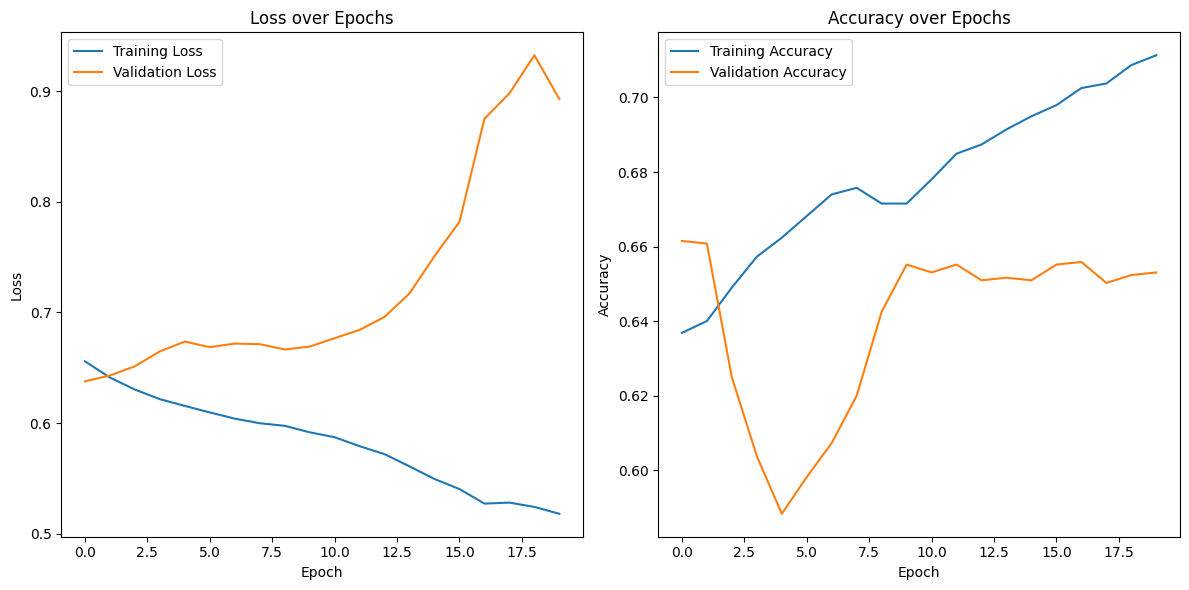

In [10]:
#Step 1: Evaluate Current Model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_fscore_support

# Load training metrics
def plot_training_metrics(metrics_file: str):
    metrics = pd.read_csv(metrics_file)
    plt.figure(figsize=(12, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(metrics['loss'], label='Training Loss')
    plt.plot(metrics['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(metrics['accuracy'], label='Training Accuracy')
    plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Evaluate dev_split performance
def evaluate_dev_split(model, dev_embeddings, dev_labels):
    predictions = model.predict(dev_embeddings).flatten()
    predictions_binary = (predictions > 0.5).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(dev_labels, predictions_binary, average='binary')
    roc_auc = roc_auc_score(dev_labels, predictions)

    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("ROC-AUC:", roc_auc)
    print("\nClassification Report:")
    print(classification_report(dev_labels, predictions_binary))

# Call these functions
plot_training_metrics('C_training_metrics.csv')  # Provide the path to your training metrics file
# evaluate_dev_split(model, dev_embeddings, dev_labels)  # Call this with your dev data and trained model


In [11]:
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import SMOTE

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def advanced_preprocess_text(text: str) -> str:
    """Preprocess text with lemmatization."""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords_set]
    return ' '.join(tokens)

def balance_classes(embeddings, labels):
    """Balance classes using SMOTE."""
    smote = SMOTE(random_state=42)
    balanced_embeddings, balanced_labels = smote.fit_resample(embeddings, labels)
    return balanced_embeddings, balanced_labels


In [12]:
#Redefine model architecture
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

def build_model(input_dim, hidden_size=200, dropout_rate=0.3, l2_reg=0.01):
    input_layer = Input(shape=(input_dim,))
    reshape_layer = tf.keras.layers.Reshape((1, input_dim))(input_layer)

    lstm_layer1 = Bidirectional(LSTM(hidden_size, return_sequences=True))(reshape_layer)
    dropout1 = Dropout(dropout_rate)(lstm_layer1)

    lstm_layer2 = Bidirectional(LSTM(hidden_size, kernel_regularizer=l2(l2_reg)))(dropout1)
    dropout2 = Dropout(dropout_rate)(lstm_layer2)

    dense_layer = Dense(100, activation='relu', kernel_regularizer=l2(l2_reg))(dropout2)
    output_layer = Dense(1, activation='sigmoid')(dense_layer)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Example usage:
# model = build_model(input_dim=X_train.shape[1])


In [13]:
def evaluate_test_split(model, test_embeddings, test_labels):
    predictions = model.predict(test_embeddings).flatten()
    predictions_binary = (predictions > 0.5).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predictions_binary, average='binary')
    roc_auc = roc_auc_score(test_labels, predictions)

    print("Test Set Performance:")
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("ROC-AUC:", roc_auc)
    print("\nClassification Report:")
    print(classification_report(test_labels, predictions_binary))

# Call this with test data
# evaluate_test_split(model, test_embeddings, test_labels)


In [14]:
def save_model_for_deployment(model, save_path="model/"):
    """Save the model as TensorFlow SavedModel."""
    model.save(save_path)
    print(f"Model saved at {save_path}")

# Wrapper for inference
def predict_from_transcripts(model, transcripts: List[str]):
    """Predict depression risk from raw transcripts."""
    processed_transcripts = [advanced_preprocess_text(text) for text in transcripts]
    embeddings = embed_model(processed_transcripts)
    predictions = model.predict(embeddings).flatten()
    return predictions > 0.5  # Returns binary predictions

# Example usage:
# save_model_for_deployment(model, save_path="depression_model/")
# predictions = predict_from_transcripts(model, ["I feel sad all the time.", "I am doing great!"])


# Regression based on PHQ8_SCORES

In [16]:
import pandas as pd
import numpy as np
import os
import logging
from pathlib import Path
import random
import re
import tensorflow_hub as hub
from typing import List, Dict, Tuple, Optional
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import mean_squared_error
import numpy as np

# Download necessary NLTK resources
# nltk.download('punkt')
# nltk.download('stopwords')
stopwords_set = set(stopwords.words('english'))

# Set seed for reproducibility
def set_seed(seed: int = 42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    # If using a GPU, set the GPU seed too
    if tf.config.list_physical_devices('GPU'):
        # CUDA devices
        pass
set_seed()

# Load Universal Sentence Encoder model from TensorFlow Hub
embed_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

class TranscriptProcessor:
    def __init__(self, data_dir: str):
        self.data_dir = Path(data_dir)
        self.stopwords = stopwords_set

    def load_transcripts(self, start_id: int = 300, end_id: int = 352, exclude_ids: List[int] = [342, 344]) -> pd.DataFrame:
        """Load and combine transcript files"""
        all_transcripts = []

        for session_id in range(start_id, end_id + 1):
            if session_id in exclude_ids:
                continue

            file_path = self.data_dir / f"{session_id}_TRANSCRIPT.csv"
            try:
                transcript = pd.read_csv(file_path, sep='\t')
                transcript['Participant_ID'] = session_id
                all_transcripts.append(transcript)
            except Exception as e:
                logging.warning(f"Error loading transcript {session_id}: {e}")

        return pd.concat(all_transcripts, ignore_index=True)

    def preprocess_text(self, text: str) -> str:
        """Clean and normalize text"""
        if isinstance(text, float):
            text = str(text)  # Convert float to string if necessary
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        tokens = word_tokenize(text)
        tokens = [t for t in tokens if t not in self.stopwords]
        return ' '.join(tokens)

    def generate_embeddings(self, texts: List[str]) -> np.ndarray:
        """Generate embeddings using Universal Sentence Encoder (USE)"""
        embeddings = embed_model(texts)
        return np.array(embeddings)

# Instead of inheriting from tf.data.Dataset, create a custom class
class DepressionDataset:
    def __init__(self, embeddings: np.ndarray, labels: np.ndarray):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

class DepressionDetectionPipeline:
    """End-to-end pipeline for depression detection"""

    def __init__(self, data_dir: str):
        self.processor = TranscriptProcessor(data_dir)

    def prepare_data(self) -> Tuple[np.ndarray, np.ndarray]:
        """Prepare data for model training"""
        transcripts = self.processor.load_transcripts()
        metadata = pd.read_csv(self.processor.data_dir / '/content/drive/MyDrive/Transcript Dataset/train_split_Depression_AVEC2017 (1).csv')
        merged_data = transcripts.merge(metadata, on='Participant_ID')
        merged_data['cleaned_text'] = merged_data['value'].apply(self.processor.preprocess_text)
        embeddings = self.processor.generate_embeddings(merged_data['cleaned_text'].tolist())
        labels = merged_data['PHQ8_Score'].values  # Use PHQ8_Scores instead of PHQ8_Binary
        return embeddings, labels

    def train_model(self, embeddings: np.ndarray, labels: np.ndarray,
                   hidden_size: int = 200, batch_size: int = 32,
                   num_epochs: int = 20) -> Tuple[tf.keras.Model, Dict]:
        X_train, X_val, y_train, y_val = train_test_split(embeddings, labels, test_size=0.2)
        # Create instances of the custom DepressionDataset class
        train_dataset = DepressionDataset(X_train, y_train)
        val_dataset = DepressionDataset(X_val, y_val)

        # Convert to TensorFlow datasets using from_generator
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
        val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)

        # Define the LSTM model using an Input layer
        input_layer = Input(shape=(X_train.shape[1],))  # Define Input layer with shape
        reshape_layer = tf.keras.layers.Reshape((1, X_train.shape[1]))(input_layer)  # Reshape

        # Rest of your LSTM layers
        lstm_layer1 = Bidirectional(LSTM(hidden_size, return_sequences=True))(reshape_layer)
        lstm_layer2 = Bidirectional(LSTM(hidden_size))(lstm_layer1)
        dense_layer1 = Dense(100, activation='relu')(lstm_layer2)
        output_layer = Dense(1, activation='linear')(dense_layer1)  # Change activation to linear for regression

        # Create the model
        model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

        model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])  # Use MSE for regression

        # Train the model
        history = model.fit(train_dataset, validation_data=val_dataset, epochs=num_epochs)

        return model, history.history
def calculate_rmse(model, embeddings, labels):
    """Calculates the RMSE of the model's predictions.

    Args:
        model: The trained regression model.
        embeddings: The input embeddings for the data.
        labels: The true PHQ8_Score labels.

    Returns:
        The RMSE value.
    """
    predictions = model.predict(embeddings)  # Get model predictions
    rmse = np.sqrt(mean_squared_error(labels, predictions))  # Calculate RMSE
    return rmse

def main():
    pipeline = DepressionDetectionPipeline('/content/drive/MyDrive/Transcript Dataset')
    embeddings, labels = pipeline.prepare_data()
    model, metrics = pipeline.train_model(embeddings, labels)
    pd.DataFrame(metrics).to_csv('R_training_metrics.csv', index=False)

    # Now calculate RMSE for the validation set
    X_train, X_val, y_train, y_val = train_test_split(embeddings, labels, test_size=0.2)
    rmse = calculate_rmse(model, X_val, y_val)
    print(f"Validation RMSE: {rmse}")

if __name__ == "__main__":
    main()


Epoch 1/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 44.7784 - mae: 5.2921 - val_loss: 24.6351 - val_mae: 4.0287
Epoch 2/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 24.5944 - mae: 4.0235 - val_loss: 24.7277 - val_mae: 4.0516
Epoch 3/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 24.3088 - mae: 4.0026 - val_loss: 24.8683 - val_mae: 4.0661
Epoch 4/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 24.1528 - mae: 3.9874 - val_loss: 24.9738 - val_mae: 4.0770
Epoch 5/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 24.0191 - mae: 3.9741 - val_loss: 25.0468 - val_mae: 4.0859
Epoch 6/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 23.8944 - mae: 3.9611 - val_loss: 25.0916 - val_mae: 4.0913
Epoch 7/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 23.7715 - mae: 3.9483 - val_loss: 25.1210 - val_mae: 4.0934
Epoch 8/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 23.6490 - mae: 3.9360 - val_loss: 25.0553 - val_mae: 4.0793
Epoch 9/20
178/178 ━━━━━━━━━━━━━━━

In [17]:
from google.colab import files

# # Assuming your DataFrame is called 'df'
# df.to_csv('training_metrics.csv', index=False)

files.download('R_training_metrics.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
from sklearn.metrics import mean_squared_error
import numpy as np

def calculate_rmse(model, embeddings, labels):
    """Calculates the RMSE of the model's predictions.

    Args:
        model: The trained regression model.
        embeddings: The input embeddings for the data.
        labels: The true PHQ8_Score labels.

    Returns:
        The RMSE value.
    """
    predictions = model.predict(embeddings)  # Get model predictions
    rmse = np.sqrt(mean_squared_error(labels, predictions))  # Calculate RMSE
    return rmse



---



model : TRF+CNN accuracy:87% recall: